In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext Cython

In [3]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics
from sklearn.metrics import roc_auc_score

In [3]:
path = 'data/'
!ls data

application_test.csv		    installments_payments.csv
application_test.csv.zip	    installments_payments.csv.zip
application_train.csv		    models
application_train.csv.zip	    POS_CASH_balance.csv
bureau_balance.csv		    POS_CASH_balance.csv.zip
bureau_balance.csv.zip		    previous_application.csv
bureau.csv			    previous_application.csv.zip
bureau.csv.zip			    sample_submission.csv
credit_card_balance.csv		    sample_submission.csv.zip
credit_card_balance.csv.zip	    subm
df_pref				    tmp
HomeCredit_columns_description.csv


# Read data

In [4]:
def display_all(df):
    with pd.option_context('display.max_rows', 1000):
        with pd.option_context('display.max_columns', 1000):
            display(df)

In [5]:
def display_allRows(df):
    with pd.option_context('display.max_rows', 1000):
        with pd.option_context('display.max_columns', 10):
            display(df)

In [ ]:
application_train = pd.read_csv(path + 'application_train.csv')
# application_test = pd.read_csv(path + 'application_test.csv')

In [19]:
# nrow = 1000
bureau_balance = pd.read_csv(path + 'bureau_balance.csv')
bureau = pd.read_csv(path + 'bureau.csv')
credit_card_balance = pd.read_csv(path + 'credit_card_balance.csv')
installments_payments = pd.read_csv(path + 'installments_payments.csv')
pos_cash_balance = pd.read_csv(path+'POS_CASH_balance.csv')
previous_application = pd.read_csv(path + 'previous_application.csv')

# Feature Engineering

Code from https://www.kaggle.com/shivamb/homecreditrisk-extensive-eda-baseline-0-772

In [20]:
data = application_train
data.shape

(307511, 122)

In [21]:
#aggregate categorical values
def agg_cat(df, group_var, df_name):
    column_names = []
    du = pd.get_dummies(df.select_dtypes('object')) #one hot encoding
    du[group_var] = df[group_var] #putting identifying id back in
    cat = du.groupby(group_var).agg(['count','mean']) #count and average all features
    for i in cat.columns.levels[0]:
        column_names.append(df_name+'_'+i+'_sum');
        column_names.append(df_name+'_'+i+'_mean');
    
    cat.columns = column_names;
    return cat
    

In [22]:
#aggregate numeric values

def agg_num(df,group_var,df_name):
    column_names = []
    df = df.select_dtypes(exclude='object') #throw out all the categorical columns, or agg.max etc will be very slow
    num = df.groupby(group_var).agg(['sum','min','max','mean'])
    for i in num.columns.levels[0]:
        for j in ['sum','min','max','mean']:
            column_names.append(df_name+'_'+i+'_'+j)
        
    num.columns = column_names
    count_column = pd.DataFrame(df.groupby(group_var).count().max(1)).rename(columns={0:df_name+'_count'})
    count_column.rename(columns = {df.columns[1]:df_name+'_count'},inplace=True)
    num = num.merge(count_column, how='left', on=group_var)
    return num

In [23]:
#Merge bureau data
bureau_data = bureau.merge(bureau_balance, how='left', on='SK_ID_BUREAU')


In [24]:
#Bureau balance

#Aggregate categorical and numeric values
#%time bur_bal_cat = agg_cat(bureau_balance,'SK_ID_BUREAU','bureau_bal')
#%time bur_bal_num = agg_num(bureau_balance,'SK_ID_BUREAU','bureau_bal')

#Merge into one
#%time bureau_bal_data = bur_bal_cat.merge(right=bur_bal_num.reset_index(),how='left', on ='SK_ID_BUREAU')

#bureau.shape, bur_bal_cat.shape, bureau_bal_data.shape ,bur_bal_num.shape

In [25]:
#Bureau data

prev_data = data #record for reference

#Aggregate categorical and numeric values
bureau_cat = agg_cat(bureau_data, 'SK_ID_CURR', 'bureau')
bureau_num = agg_num(bureau_data, 'SK_ID_CURR', 'bureau')

#Merge into data
data = data.merge(right=bureau_cat.reset_index(), how='left', on='SK_ID_CURR')
data = data.merge(right=bureau_num.reset_index(), how='left', on='SK_ID_CURR')

#print out size to check
prev_data.shape, bureau_cat.shape, bureau_num.shape, data.shape

((307511, 122), (305811, 62), (305811, 57), (307511, 241))

In [26]:
#Previous applications

prev_data = data #record for reference

#Count previous application
prev_apps_cat = agg_cat(previous_application,'SK_ID_CURR','prev_apps')
prev_apps_num = agg_num(previous_application,'SK_ID_CURR','prev_apps')

#Merge into data
data = data.merge(right=prev_apps_cat.reset_index(), how='left', on='SK_ID_CURR')
data = data.merge(right=prev_apps_num.reset_index(), how='left', on='SK_ID_CURR')

#print out size to check
prev_data.shape, prev_apps_cat.shape, prev_apps_num.shape, data.shape

((307511, 241), (338857, 286), (338857, 81), (307511, 608))

In [27]:
#Installments Payments

## Average values for all other variables in installments payments
#avg_inst_cat = agg_cat(installments_payments,'SK_ID_CURR','avg_inst') #no categorical values
avg_inst_num = agg_num(installments_payments,'SK_ID_CURR','avg_inst')

#Merge into data
#data = data.merge(right=avg_inst_cat.reset_index(), how='left', on='SK_ID_CURR') #no categorical values
data = data.merge(right=avg_inst_num.reset_index(), how='left', on='SK_ID_CURR')

avg_inst_num.shape, data.shape

((339587, 29), (307511, 637))

In [28]:
#Pos cash balance

### count the number of pos cash for a given ID
pcb_cat = agg_cat(pos_cash_balance,'SK_ID_CURR','Pos_cash_bal')
pcb_num = agg_num(pos_cash_balance,'SK_ID_CURR','Pos_cash_bal')

#Merge data
data = data.merge(right=pcb_cat.reset_index(), how='left', on='SK_ID_CURR')
data = data.merge(right=pcb_num.reset_index(), how='left', on='SK_ID_CURR')

pcb_cat.shape, pcb_num.shape, data.shape

((337252, 18), (337252, 25), (307511, 680))

In [29]:
#Credit card balance

cc_bal_cat = agg_cat(credit_card_balance,'SK_ID_CURR','credit_card_bal')
cc_bal_num = agg_num(credit_card_balance,'SK_ID_CURR','credit_card_bal')

#Merge data
data = data.merge(right=cc_bal_cat.reset_index(), how='left', on='SK_ID_CURR')
data = data.merge(right=cc_bal_num.reset_index(), how='left', on='SK_ID_CURR')

data.shape

(307511, 779)

In [30]:
#Save data
data.to_feather('tmp/data')
!ls tmp

data  data_test


In [177]:
#Better Feature Engineering: 
#https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering-p2
#https://www.kaggle.com/willkoehrsen/feature-selection

# Learning

In [4]:
#df_merge = pd.read_feather('tmp/df_merge')
data = pd.read_feather('tmp/data')
data.shape

(307511, 779)

In [5]:
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,credit_card_bal_CNT_INSTALMENT_MATURE_CUM_mean,credit_card_bal_SK_DPD_sum,credit_card_bal_SK_DPD_min,credit_card_bal_SK_DPD_max,credit_card_bal_SK_DPD_mean,credit_card_bal_SK_DPD_DEF_sum,credit_card_bal_SK_DPD_DEF_min,credit_card_bal_SK_DPD_DEF_max,credit_card_bal_SK_DPD_DEF_mean,credit_card_bal_count
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Balancing

In [36]:
# Data balancing
# data_sub = data[data['TARGET']==1]
# a=0;
# data_append = data_sub
# for i in range(9):
#     data_append = data_append.append(data_sub)
# data_append.shape

In [38]:
# data = data.append(data_append)
# data.shape

In [39]:
#data = data.reset_index()

In [42]:
#data = data.drop(columns = ['index'])

In [18]:
#data.to_feather('tmp/data_balanced')

In [4]:
#data = pd.read_feather('tmp/data_balanced')

In [6]:
#data.head()

# Traning setup

In [7]:
train_cats(data)
#train_cats(df_app)

In [8]:
df, y, nas = proc_df(data,'TARGET')#option max_n_cat=8
#df, y, nas = proc_df(df_app,'TARGET')

In [9]:
df.shape

(307511, 1496)

In [10]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 8000
n_trn = len(df) - n_valid
#raw_train, raw_valid = split_vals(df_app, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((299511, 1496), (299511,), (8000, 1496), (8000,))

In [11]:
def rmse(x,y):
    return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [roc_auc_score(y_train, m.predict(X_train)), roc_auc_score(y_valid, m.predict(X_valid)),
          m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m,'oob_score_'): res.append(m.oob_score_)
    print(res)

In [12]:
set_rf_samples(20000) # use reset_rf_samples() to reset

# Feature Importance

In [13]:
m = RandomForestClassifier(n_estimators=40, n_jobs=-1, max_depth=12, min_samples_leaf=30, 
                           max_features='sqrt', oob_score=True, class_weight='balanced')
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 1min 37s, sys: 22.8 s, total: 2min
Wall time: 1min 48s
[0.6391818217366037, 0.6387003682218235, 0.8478085946759886, 0.848625, 0.8423630517743923]


In [14]:
# m = RandomForestRegressor(n_estimators=40, n_jobs=-1, max_depth=12, min_samples_leaf=30, max_features='sqrt', oob_score=True, random_state=2018)
# %time m.fit(X_train, y_train)
# print_score(m)

In [15]:
fi = rf_feat_importance(m,X_train); fi[:10]

,cols,imp
41,EXT_SOURCE_2,0.044911
42,EXT_SOURCE_3,0.038468
40,EXT_SOURCE_1,0.018036
16,DAYS_BIRTH,0.015358
190,bureau_DAYS_CREDIT_mean,0.012178
189,bureau_DAYS_CREDIT_max,0.009222
188,bureau_DAYS_CREDIT_min,0.008532
17,DAYS_EMPLOYED,0.008477
632,avg_inst_AMT_PAYMENT_min,0.008155
122,bureau_CREDIT_ACTIVE_Active_mean,0.007549


In [16]:
def plot_fi(fi): return fi.plot('cols','imp','barh',figsize=(12,8), legend=False)

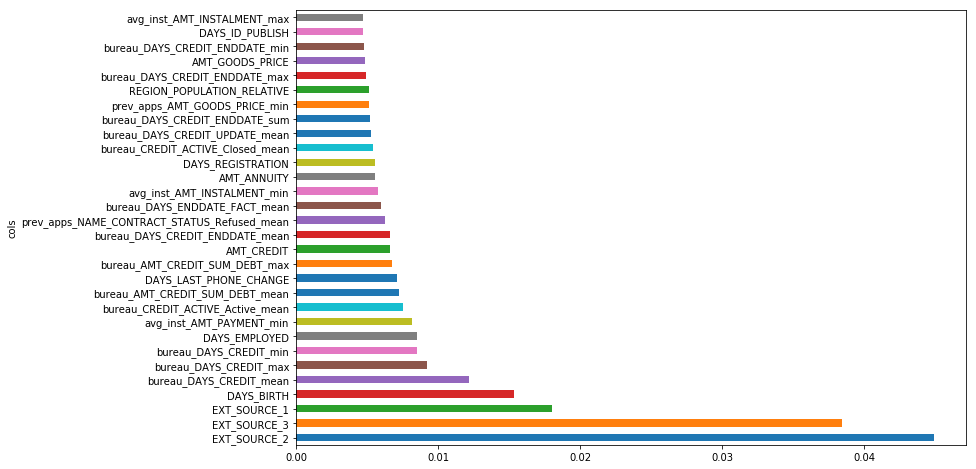

In [17]:
plot_fi(fi[:30])

# Improving results

In [18]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

25

In [19]:
df_keep = data[to_keep].copy()

In [20]:
df, _, nas = proc_df(df_keep)

In [21]:
df.shape

(307511, 45)

In [22]:
X_train, X_valid = split_vals(df, n_trn)

In [23]:
m = RandomForestClassifier(n_estimators=40, n_jobs=-1, max_depth=8, min_samples_leaf=30, 
                           max_features='sqrt', oob_score=True, class_weight='balanced')
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 8.74 s, sys: 620 ms, total: 9.36 s
Wall time: 5.66 s
[0.6729423474147338, 0.660413880198117, 0.7494148795870602, 0.73825, 0.7465068060939332]


In [24]:
m = RandomForestClassifier(n_estimators=300, n_jobs=-1, max_depth=8, min_samples_leaf=30, 
                           max_features='sqrt', oob_score=True, class_weight='balanced')
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 1min 1s, sys: 4.13 s, total: 1min 5s
Wall time: 36.3 s
[0.6766609605506262, 0.6706762439589797, 0.7536183979887217, 0.743625, 0.7512078020506759]


# Cluster analysis

In [28]:
#Remove redundant features
from scipy.cluster import hierarchy as hc

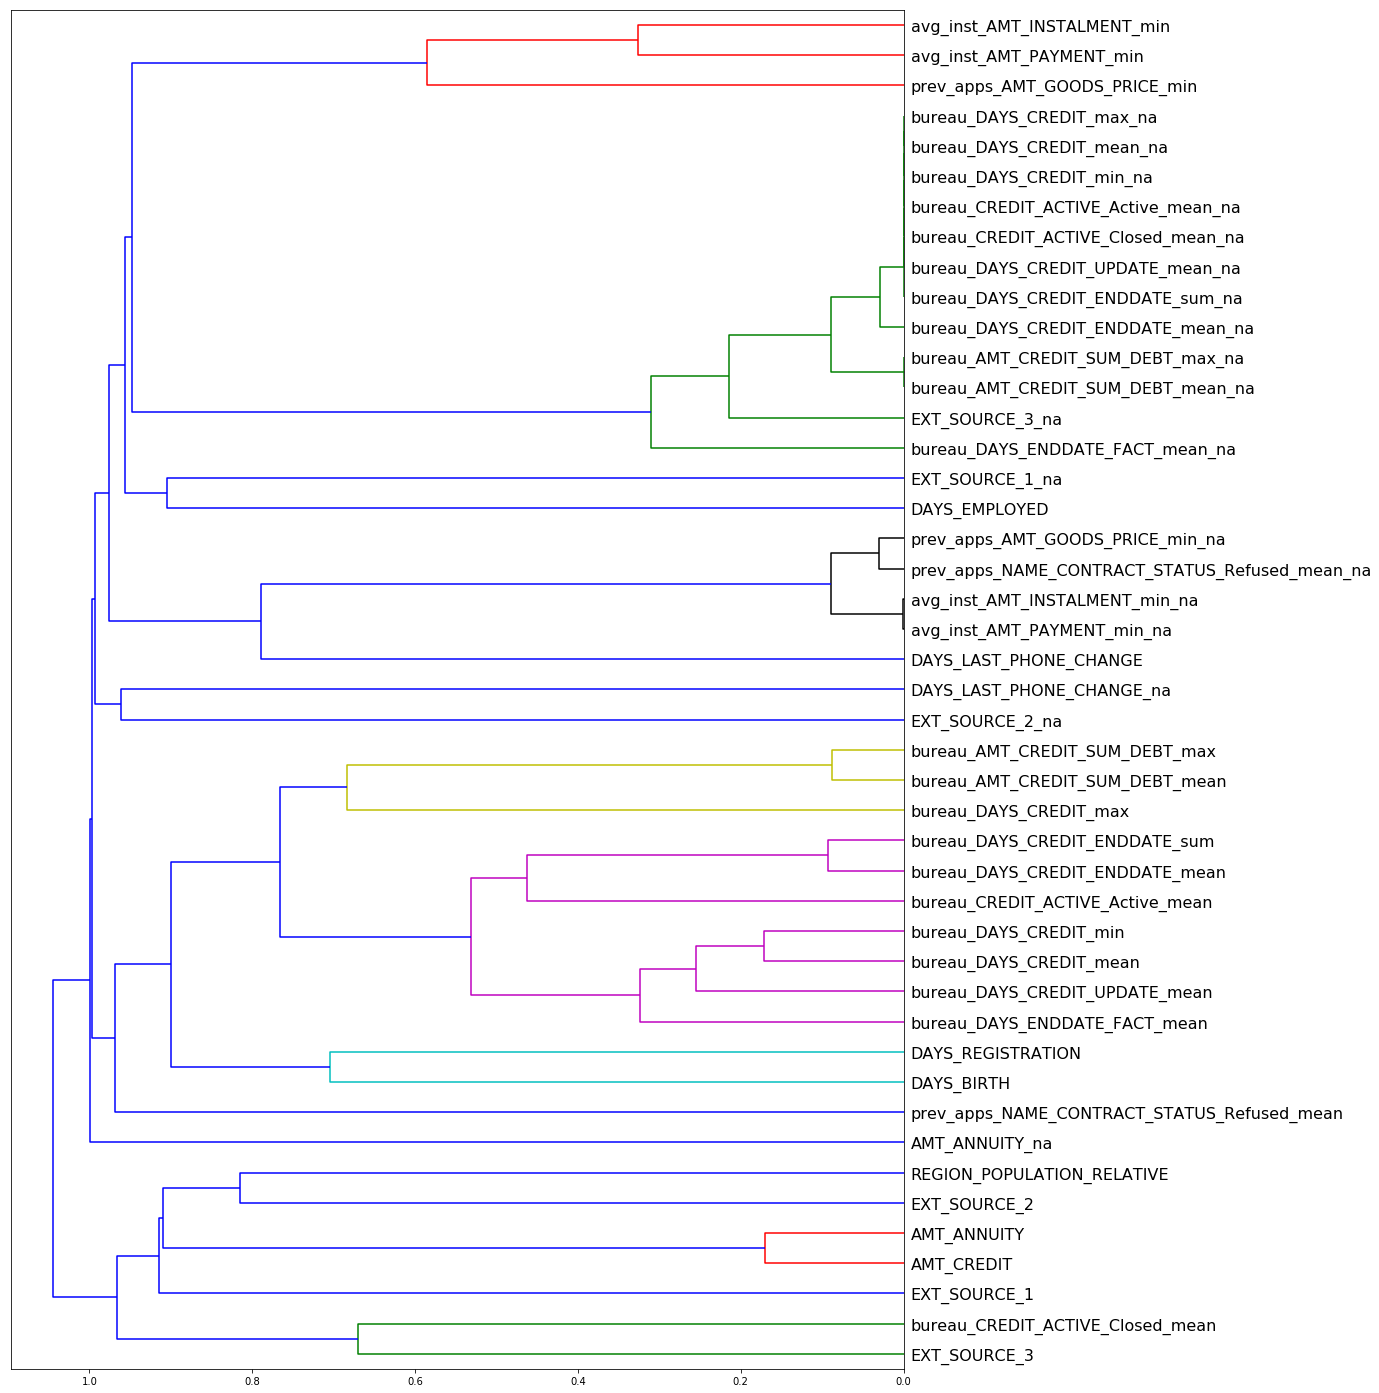

In [27]:
corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,25))
dendrogram = hc.dendrogram(z,labels=df.columns, orientation='left', leaf_font_size=16)
plt.show()

# Test set

In [153]:
df_app_test = pd.read_csv(f'{PATH}application_test.csv', low_memory=False)

In [163]:
test_data = pd.read_feather('tmp/test_data')
test_data.shape

(48744, 189)

In [164]:
apply_cats(test_data, df_keep)

In [165]:
df_test_fi = test_data[to_keep].copy()

In [166]:
df_test_fi.shape

(48744, 60)

In [167]:
#df, y, nas = proc_df(df_app,'TARGET')

df_test,a,b = proc_df(df_test_fi,na_dict=nas) #passing in na_dict make sure the missing value columns aligns with training set

In [168]:
df_test.shape

(48744, 108)

In [169]:
predict = m.predict(df_test)

In [170]:
predict

array([0.11481, 0.12088, 0.04674, ..., 0.04852, 0.0457 , 0.16747])

In [171]:
df_pred = pd.DataFrame(predict)

In [172]:
df_pred.insert(0,'SK_ID_CURR',df_app_test['SK_ID_CURR'])

In [173]:
df_pred.rename({0:'TARGET'},axis='columns',inplace=True)

In [174]:
df_pred.head()

,SK_ID_CURR,TARGET
0,100001,0.114809
1,100005,0.120876
2,100013,0.046737
3,100028,0.049196
4,100038,0.133846


In [175]:
df_pred.to_feather(f'{PATH}df_pref')

In [176]:
SUBM = f'{PATH}subm/'
os.makedirs(SUBM,exist_ok=True)
df_pred.to_csv(f'{SUBM}subm.csv', index = False)
FileLink(f'{SUBM}subm.csv')

/home/paperspace/kaggle/competitions/home-credit-default-risk/data/subm/subm.csv